In [1]:
#!git clone https://github.com/sobrad956/CMSC472FinalProject.git

Cloning into 'CMSC472FinalProject'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 23 (delta 10), reused 17 (delta 8), pack-reused 0
Unpacking objects: 100% (23/23), 6.18 KiB | 791.00 KiB/s, done.


In [2]:
#!cd CMSC472FinalProject/

In [1]:
import torch
import torchvision as tv
import torch.random
import os
import sys
from PIL import Image
from torchvision import transforms
from torchvision.datasets import Food101
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt 
import matplotlib

In [2]:
# assumes original color temp maxed out at (255,255,255)
# expect Tensor of [..., 3 (r,g,b), H, W]
class RandomSaltPepper(torch.nn.Module):
    def __init__(self, p=0.5, type='salt'):
        super().__init__()
        self.p = p
        self.salt = type in ['salt', 'both']
        self.pepper = type in ['pepper', 'both']
        self.color = []
        if self.salt:
            self.color.append(1)
        if self.pepper:
            self.color.append(0)
    
    def forward(self, imgs):
        if not len(self.color):
            return imgs
                    
        # probably slow AF and not pythonic
        for i, img in enumerate(imgs):
            for h, row in enumerate(img[0]):
                for w, _ in enumerate(row):
                    if torch.rand(1) < self.p:
                        imgs[i,:,h,w] = self.color[torch.randint(0, len(self.color), (1,)).item()]
        
        return imgs

class RandomGaussianNoise(torch.nn.Module):
    def __init__(self, mean=0, var=1):
        super().__init__()
        self.mean = mean
        self.var = var
        self.sigma = var ** 0.5
        
    def forward(self, imgs):
        noise = torch.normal(self.mean, self.sigma, imgs.shape)
        imgs += noise
        imgs = torch.clamp(imgs, 0, 1)
        return imgs


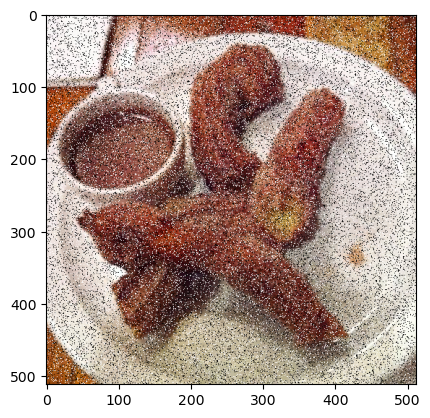

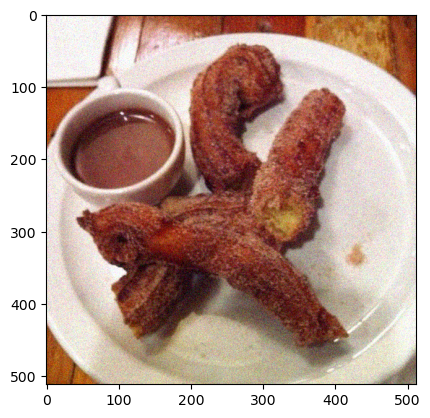

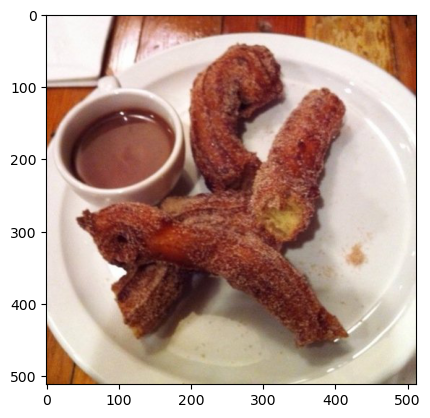

In [3]:
# simple testbench
if __name__ == '__main__':
    root = os.path.expanduser(os.path.join('~', 'data'))
    dataset = Food101(root=root, download=False, transform=ToTensor())
    aug = RandomSaltPepper(p=0.2, type='both')
    aug2 = RandomGaussianNoise(mean=0,var=1./255.)
    oim = torch.unsqueeze(dataset[0][0], 0)
    aim = aug(torch.clone(oim))
    aim2 = aug2(torch.clone(oim))
    plt.figure(0)
    plt.imshow(aim[0].permute(1,2,0))
    plt.figure(1)
    plt.imshow(aim2[0].permute(1,2,0))
    plt.figure(2)
    plt.imshow(oim[0].permute(1,2,0))
    plt.show()

In [4]:
len(dataset)

75750

In [16]:
# MODELLED AFTER https://github.com/gsp-27/pytorch_Squeezenet

In [5]:
import squeezenet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import argparse
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import embed
import shutil

In [14]:
def getschedule(epoch):
    p = dict()
    regimes = [[1, 18, 5e-3, 5e-4],
               [19, 29, 1e-3, 5e-4],
               [30, 43, 5e-4, 5e-4],
               [44, 52, 1e-4, 0],
               [53, 1e8, 1e-5, 0]]
    # regimes = [[1, 18, 1e-4, 5e-4],
    #            [19, 29, 5e-5, 5e-4],
    #            [30, 43, 1e-5, 5e-4],
    #            [44, 52, 5e-6, 0],
    #            [53, 1e8, 1e-6, 0]]
    for i, row in enumerate(regimes):
        if epoch >= row[0] and epoch <= row[1]:
            p['learning_rate'] = row[2]
            p['weight_decay'] = row[3]
    return p

def main():
    batchSz = 64
    nEpochs = 55
    lr = 0.001
    wd = 5e-4
    momentum = 0.9
    cuda = torch.cuda.is_available()
    log_schedule = 10
    seed = 1
    model_name = None
    testing = False
    num_classes = 101
    epoch_55 = True
    save = 'work/squeezenet.base'
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)
        
    if os.path.exists(save):
        shutil.rmtree(save)
    os.makedirs(save, exist_ok=True)
    
    trainTransform = transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.491399689874, 0.482158419622, 0.446530924224), (0.247032237587, 0.243485133253, 0.261587846975))
    ])
    
    testTransform = transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.491399689874, 0.482158419622, 0.446530924224), (0.247032237587, 0.243485133253, 0.261587846975))
    ])
    
    trainLoader = DataLoader(Food101(root=root, split="train", transform=trainTransform), batch_size = batchSz, shuffle=True)
    testLoader = DataLoader(Food101(root=root, split="test", transform=testTransform), batch_size = batchSz, shuffle=True)

    net = squeezenet.SqueezeNet()
    print('  + Number of params: {}'.format(sum([p.data.nelement() for p in net.parameters()])))
    if model_name is not None:
        print("loading pre trained weights")
        pretrained_weights = torch.load(model_name)
        net.load_state_dict(pretrained_weights)
    if cuda:
        net.cuda()
        
    trainF = open(os.path.join(save, 'train.csv'), 'w')
    testF = open(os.path.join(save, 'test.csv'), 'w')
    for epoch in range(1, nEpochs+1):
        if epoch_55:
            schedule = getschedule(epoch)
            lr = schedule['learning_rate']
            wd = schedule['weight_decay']
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=wd)
        train(cuda, epoch, net, trainLoader, optimizer, trainF)
        test(cuda, epoch, net, testLoader, optimizer, testF)
        torch.save(net, os.path.join(save, 'latest.pth'))
        os.system('./plot.py {} &'.format(save))
    trainF.close()
    testF.close()

def train(cuda, epoch, net, trainLoader, optimizer, trainF):
    net.train()
    nProcessed = 0
    nTrain = len(trainLoader.dataset)
    for batch_idx, (data, target) in enumerate(trainLoader):
        if(nProcessed > 400):
          break
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = net(data).squeeze()
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        nProcessed += len(data)
        pred = output.data.max(1)[1] # get the index of the max log-probability
        incorrect = pred.ne(target.data).cpu().sum()
        err = 100.*incorrect/len(data)
        partialEpoch = epoch + batch_idx / len(trainLoader) - 1
        print('Train Epoch: {:.2f} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tError: {:.6f}'.format(
            partialEpoch, nProcessed, nTrain, 100. * batch_idx / len(trainLoader),
            loss.item(), err))

        trainF.write('{},{},{}\n'.format(partialEpoch, loss.item(), err))
        trainF.flush()

def test(cuda, epoch, net, testLoader, optimizer, testF):
    net.eval()
    test_loss = 0
    incorrect = 0
    for batch_idx, (data, target) in enumerate(testLoader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = net(data).squeeze()
        test_loss += F.nll_loss(output, target)
        pred = output.data.max(1)[1] # get the index of the max log-probability
        incorrect += pred.ne(target.data).cpu().sum()
    test_loss /= len(testLoader) # loss function already averages over batch size
    nTotal = len(testLoader.dataset)
    err = 100.*incorrect/nTotal
    print('\nTest set: Average loss: {:.4f}, Error: {}/{} ({:.0f}%)\n'.format(
        test_loss, incorrect, nTotal, err))

    testF.write('{},{},{}\n'.format(epoch, test_loss, err))
    testF.flush()

In [15]:
main()

  + Number of params: 781669
Train Epoch: 0.00 [64/75750 (0%)]	Loss: 4.756156	Error: 100.000000
Train Epoch: 0.00 [128/75750 (0%)]	Loss: 4.686281	Error: 100.000000
Train Epoch: 0.00 [192/75750 (0%)]	Loss: 4.705647	Error: 98.437500
Train Epoch: 0.00 [256/75750 (0%)]	Loss: 4.750705	Error: 98.437500
Train Epoch: 0.00 [320/75750 (0%)]	Loss: 4.730057	Error: 98.437500
Train Epoch: 0.00 [384/75750 (0%)]	Loss: 4.744040	Error: 100.000000
Train Epoch: 0.01 [448/75750 (1%)]	Loss: 4.675154	Error: 100.000000


KeyboardInterrupt: 